<img src="https://www.lsce.ipsl.fr/Css/img/banniere_LSCE_75.png" width="600px">

## Extracting continent shorelines

### Example with a paleo orca 2.3 configuration

- Author: Patrick Brockmann
- Version: 22/11/2022

In [1]:
import numpy as np
import xarray as xr

In [2]:
#ds = xr.open_dataset("https://thredds-su.ipsl.fr/thredds/dodsC/ipsl_thredds/brocksce/PALEORCA2.3/14Ma/IPSL.PALEORCA2_gridCF.nc")
ds = xr.open_dataset("https://thredds-su.ipsl.fr/thredds/dodsC/ipsl_thredds/brocksce/PALEORCA2.3/17Ma/IPSL.PALEORCA2_gridCF.nc")
ds

<xarray.Dataset>
Dimensions:       (y: 149, x: 182, four: 4, depth: 31, two: 2)
Coordinates:
    lon           (y, x) float32 ...
    lat           (y, x) float32 ...
  * depth         (depth) float32 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y, x, four, two
Data variables:
    bounds_lon    (y, x, four) float32 ...
    bounds_lat    (y, x, four) float32 ...
    bounds_depth  (depth, two) float32 ...
    MASK          (depth, y, x) float32 ...
    MASKDRAW      (depth, y, x) float32 ...
    VOL           (depth, y, x) float32 ...
    AREA          (y, x) float32 ...
    BATHY         (y, x) float32 ...
Attributes:
    Conventions:  CF-1.1
    institution:  PALEORCA2
    production:   NEMO

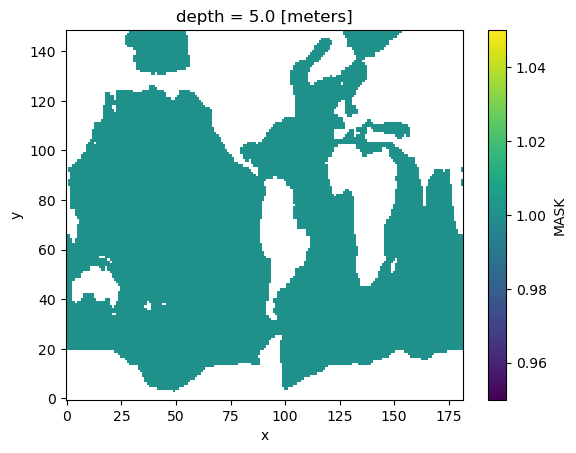

In [3]:
# MASKDRAW or MASK can be used since duplicate polys will be removed later
#mask = xr.where(ds['MASKDRAW'].isel(depth=0) == 1, 1, np.nan)
mask = xr.where(ds['MASK'].isel(depth=0) == 1, 1, np.nan)
mask.plot()

In [4]:
# build boundaries and and mask them

mask = xr.where(ds['MASK'].isel(depth=0) == 1, 1, np.nan)

mask = mask.to_numpy().reshape(-1)
print(mask.shape)

mask1 = mask[~np.isnan(mask)]
#mask1 = mask
print(mask1.shape[0])

blon = ds['bounds_lon'].to_numpy()
blat = ds['bounds_lat'].to_numpy()
nvertex = blon.shape[-1]
print(nvertex)

blon = blon.reshape(-1, nvertex)
blat = blat.reshape(-1, nvertex)
print(blon.shape)

mask = np.repeat(mask, nvertex).reshape(mask.shape[0], nvertex)

blon = blon[~np.isnan(mask)].reshape(mask1.shape[0], nvertex)
blat = blat[~np.isnan(mask)].reshape(mask1.shape[0], nvertex)
print(blon.shape)

(27118,)
16385
4
(27118, 4)
(16385, 4)


In [5]:
deg2rad = np.pi/180.
x = np.cos(blat*deg2rad)*np.cos(blon*deg2rad)
y = np.cos(blat*deg2rad)*np.sin(blon*deg2rad)
z = np.sin(blat*deg2rad)

In [6]:
# Structures for polydata
points = np.stack((x,y,z), axis=2).reshape(x.size, 3)
faces = np.arange(x.shape[0] * nvertex).reshape(x.shape[0], nvertex)
faces = np.insert(faces, 0, nvertex, axis=1)

In [7]:
import pyvista as pv

In [8]:
mesh = pv.PolyData(points, faces)
mesh

PolyData,Information
N Cells,16385
N Points,65540
N Strips,0
X Bounds,"-1.000e+00, 1.000e+00"
Y Bounds,"-1.000e+00, 1.000e+00"
Z Bounds,"-9.748e-01, 1.000e+00"
N Arrays,0


In [9]:
# Clean polydata with tolerance set
mesh = pv.PolyData(points, faces)
mesh.clean(inplace=True, tolerance=0.001)
mesh

PolyData,Information
N Cells,16385
N Points,17032
N Strips,0
X Bounds,"-1.000e+00, 1.000e+00"
Y Bounds,"-1.000e+00, 1.000e+00"
Z Bounds,"-9.748e-01, 1.000e+00"
N Arrays,0


In [10]:
import vtk

In [11]:
# Duplicate cells removed
removePolyData = vtk.vtkRemoveDuplicatePolys()
removePolyData.SetInputData(mesh)
removePolyData.Update()

mesh = removePolyData.GetOutput()
mesh = pv.wrap(mesh)
mesh

PolyData,Information
N Cells,16233
N Points,17032
N Strips,0
X Bounds,"-1.000e+00, 1.000e+00"
Y Bounds,"-1.000e+00, 1.000e+00"
Z Bounds,"-9.748e-01, 1.000e+00"
N Arrays,0


In [12]:
edges = mesh.extract_feature_edges(boundary_edges=True)
edges

PolyData,Information
N Cells,1624
N Points,1623
N Strips,0
X Bounds,"-7.855e-01, 9.972e-01"
Y Bounds,"-9.779e-01, 9.900e-01"
Z Bounds,"-9.748e-01, 9.941e-01"
N Arrays,0


In [15]:
import pyvista as pv
import vtk

vtk.vtkLogger.SetStderrVerbosity(vtk.vtkLogger.VERBOSITY_OFF)

edges = mesh.extract_feature_edges(boundary_edges=True)

pl = pv.Plotter()
pl.set_background('white')

actor1 = pl.add_mesh(pv.Sphere(radius=0.999, theta_resolution=360, phi_resolution=180))
actor2 = pl.add_mesh(mesh, show_edges=True, edge_color="gray")
actor3 = pl.add_mesh(edges, color="red", line_width=2)
viewer = pl.show(jupyter_backend='panel', return_viewer=True)
display(viewer)

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, sizing_mode='stretch_width')

In [16]:
edges.GetNumberOfLines()

1624

In [17]:
edges.connectivity()

PolyData (0x7f0bc3d80e80)
  N Cells:	1624
  N Points:	1623
  N Strips:	0
  X Bounds:	-7.855e-01, 9.972e-01
  Y Bounds:	-9.779e-01, 9.900e-01
  Z Bounds:	-9.748e-01, 9.941e-01
  N Arrays:	2

In [18]:
regions = edges.connectivity()
regCount = len(set(pv.get_array(regions ,name="RegionId")))
regCount

14

In [19]:
import random

In [25]:
pl = pv.Plotter()
pl.add_mesh(pv.Sphere(radius=0.999, theta_resolution=360, phi_resolution=180))

CONT_LON = []
CONT_LAT = []

regions = edges.connectivity()
regCount = len(set(pv.get_array(regions, name="RegionId")))

connectivityFilter = vtk.vtkPolyDataConnectivityFilter()
stripper = vtk.vtkStripper()

for r in range(regCount):
    connectivityFilter.SetInputData(edges)
    connectivityFilter.SetExtractionModeToSpecifiedRegions()
    connectivityFilter.InitializeSpecifiedRegionList()
    connectivityFilter.AddSpecifiedRegion(r)
    connectivityFilter.Update()
    
    reg = connectivityFilter.GetOutput()
    
    stripper.SetInputData(reg)
    stripper.SetJoinContiguousSegments(True)
    stripper.Update()
    reg = stripper.GetOutput()
      
    pts = reg.GetCell(0).GetPoints()
    thetas = []
    phis = []
    for i in range(pts.GetNumberOfPoints()):
        x,y,z = pts.GetPoint(i)
        theta   =  90 - np.arccos(z)*180 / np.pi
        phi     =  np.arctan2(y,x)*180 / np.pi
        phis.append(phi)
        thetas.append(theta)
    # as to be reversed https://github.com/SciTools/cartopy/issues/2103
    CONT_LON.extend(reversed(phis))
    CONT_LAT.extend(reversed(thetas))
    CONT_LON.append(-1E34)
    CONT_LAT.append(-1E34)
    
    random_color = "#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
    pl.add_mesh(reg, color=random_color, line_width=2)
    
viewer = pl.show(jupyter_backend='panel', return_viewer=True)
display(viewer)    

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, sizing_mode='stretch_width')

In [21]:
import netCDF4

rootgrp = netCDF4.Dataset("paleo_continents.nc", "w", format="NETCDF4", clobber=True)
npoints = rootgrp.createDimension("npoints", None)
longitudes = rootgrp.createVariable("CONT_LON","f8",("npoints",))
latitudes = rootgrp.createVariable("CONT_LAT","f8",("npoints",))
longitudes[:] = CONT_LON
latitudes[:] = CONT_LAT
longitudes.missing_value = -1.E+34
latitudes.missing_value = -1.E+34
rootgrp.close()

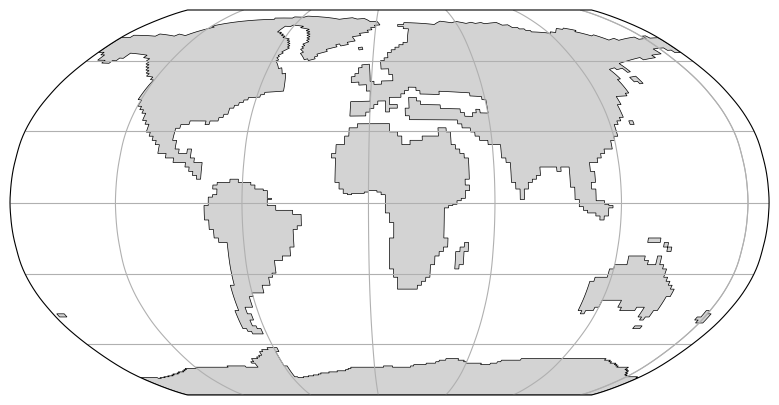

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

ds = xr.open_dataset("paleo_continents.nc")

x = ds['CONT_LON'] ; y = ds['CONT_LAT']

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(10))

#transform = ccrs.PlateCarree()
transform = ccrs.Geodetic()

#ax.plot(x, y, transform=transform, color='red', lw=0.5)
ax.fill(x, y, transform=transform, color='lightgray', lw=0.5, edgecolor="black")
ax.set_global()
ax.gridlines()
plt.show()

ds.close()

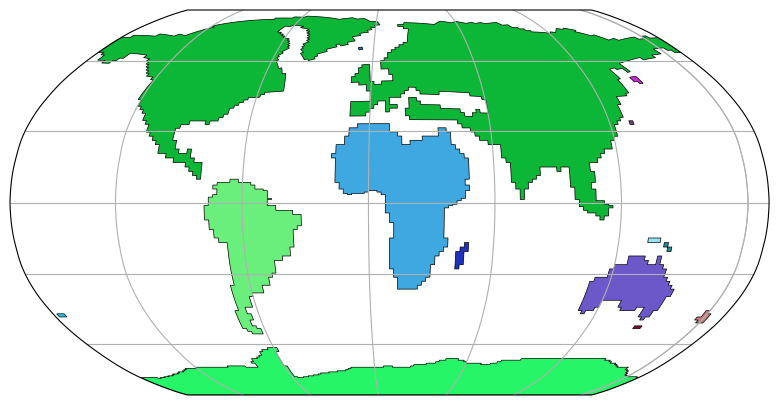

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

ds = xr.open_dataset("paleo_continents.nc")

x = ds['CONT_LON'] ; y = ds['CONT_LAT']

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(10))

transform = ccrs.Geodetic()

indices = np.where(np.isnan(x.values))[0]
#print(indices)

indice_curr = 0
for indice in indices:
    xselect = x[indice_curr:indice]
    yselect = y[indice_curr:indice]
    random_color = "#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
    #ax.plot(xselect, yselect, transform=transform, color=random_color, lw=0.5)
    ax.fill(xselect, yselect, transform=transform, color=random_color, lw=0.5, edgecolor="black")
    indice_curr = indice+1
    

ax.set_global()
ax.gridlines()
plt.show()

ds.close()